1. furnance와 molten_volume 둘다 없는 것 'D'로 나머지 furnance 'C' -> 'D' 모두 드랍 (O)
2. 이상치 처리 
    - lof, iso 유지 (O)
    - 이상치 처리 방식 추가
        1. IQR 방식
            - IQR의 계수를 10까지 늘렸을 떄,
                - 데이터 수 : 92014 -> 46650
                - 불합격 데이터 비율 : 4.36% -> 1.04% (fail 데이터가 4000여개 중 3500여개 사라짐)
            - 10 이상으로 늘려도 값은 같았음
            - 결론 : 적용하지 않는 것이 좋겠음
        2. Percentile
3. 불균형 처리
    - ADASYN 추가
    - (선택) mold_code 기준 많은 code만 제거 (8722, 8412 -> 20000, 8917->30000)
4. PCA

# Data Load

In [7]:
from kamp.preprocess import KampDataLoader

DATA_PATH = './data/경진대회용 주조 공정최적화 데이터셋.csv'

data_loader = KampDataLoader(
    path = DATA_PATH,

    outlier_method='iso',
    iso_outlier_rate=0.0075, # 0.0075

    p_threshold=0.05,
    get_useful_p_data=True,
                             
    do_resample=False,
    downsampled_pass_rate=1.0,
    upsampled_total_fail_rate=0.40
)

data_loader.process()

data = data_loader.load()

x_train = data['train_data']
y_train = data['train_label']
x_test = data['test_data']
y_test=  data['test_label']

==================== [Data Process Start] ==================== 

[process Log] Loading Raw Data...
[process Log] Done

[process Log] Processing Nan Value...
[process Log] Done

[process Log] Encoding Categorical Features...
[process Log] Done

[process Log] Removing Outliers (IsoForest)...
[Outlier-Remover Log] With Outliers Shape : (92014, 23)
[Outlier-Remover Log] Without Outliers Shape : (91323, 23)
[process Log] Done

[process Log] T-Testing...
[process Log] Done

[process Log] Data Scaling (MinMaxScaler)...
[process Log] Done

[process Log] Train Test Spliting...
[process Log] Done

[process Log] Data Resampling...
[process Log] Done

train : [1 0]
test : [1 0]
======================= [Done] =======================


In [8]:
len(x_train.columns)

19

# CSV 저장

In [9]:
import pandas as pd
df_train = pd.DataFrame()
df_train = pd.DataFrame(x_train)
df_train['passorfail'] = pd.DataFrame(y_train)
df_test = pd.DataFrame()
df_test = pd.DataFrame(x_test)
df_test['passorfail'] = pd.DataFrame(y_test)
df_train.to_csv('train_resample.csv', index=True, encoding='utf-8')
df_test.to_csv('test_resample.csv', index=True, encoding='utf-8')

In [10]:
x_train = pd.read_csv('train_resample.csv').drop(columns=['passorfail','Unnamed: 0'])
y_train =pd.read_csv('train_resample.csv')['passorfail']
x_test = pd.read_csv('test_resample.csv').drop(columns=['passorfail','Unnamed: 0'])
y_test = pd.read_csv('test_resample.csv')['passorfail']

In [11]:
x_test.head()

,count,working,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,upper_mold_temp2,lower_mold_temp1,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,EMS_operation_time,tryshot_signal,mold_code,heating_furnace
0,0.438438,1,0.128866,0.251546,0.700000,0.757732,0.890909,0.075829,0.128151,0.037337,0.561605,0.163165,0.017637,0.304501,0.936228,1,0.0,1,1
1,0.804805,1,0.126289,0.245361,0.733333,0.288660,0.822727,0.132701,0.134454,0.041855,0.464183,0.168768,0.017637,0.315049,0.971506,0,0.0,1,0
2,0.381381,1,0.118557,0.241237,0.733333,0.288660,0.877273,0.132701,0.144258,0.031867,0.335244,0.144258,0.017637,0.121660,0.964722,0,0.0,0,0
3,0.588589,1,0.131443,0.251546,0.733333,0.288660,0.918182,0.104265,0.111345,0.032342,0.724928,0.125350,0.017637,0.321378,0.963365,1,0.0,1,1
4,0.054054,1,0.126289,0.249485,0.726667,0.288660,0.922727,0.116114,0.138655,0.033056,0.604585,0.100840,0.017637,0.388186,0.963365,1,0.0,1,1


# Modeling

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

strat_folder = StratifiedShuffleSplit(
    n_splits=10,
    random_state=42,
    test_size=0.2
)

c:\Users\Playdata\AppData\Local\anaconda3\envs\ag\lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [13]:
def modelTest(model):
    fold_f1_score = []
    n_iter = 0
    idx_list = []

    for train_idx, val_idx in strat_folder.split(x_train, y_train):
        train_data, val_data = x_train.iloc[train_idx], x_train.iloc[val_idx]
        train_label, val_label = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(train_data, train_label)

        val_pred = model.predict(val_data)
        val_f1_score = f1_score(val_label, val_pred)
        val_report = classification_report(val_label, val_pred)

        n_iter += 1
        fold_f1_score.append([n_iter, val_f1_score])
        idx_list.append([train_idx, val_idx])

        print(f"StratifiedShuffleSplit {n_iter} 검증 데이터 f1 score : {val_report}")

    fold_f1_score.sort(key=lambda x : x[1], reverse=True)
    print(pd.DataFrame(fold_f1_score, columns=['Fold', 'F1']))

    best_fold_train_idx = idx_list[fold_f1_score[0][0]-1][0]
    best_fold_val_idx = idx_list[fold_f1_score[0][0]-1][1]
    model.fit(x_train.iloc[best_fold_train_idx], y_train.iloc[best_fold_train_idx])

    plt.figure(figsize=(15,5))

    # validation
    plt.subplot(1,2,1)
    pred = model.predict(x_train.iloc[best_fold_val_idx])
    cm = confusion_matrix(y_train[best_fold_val_idx], pred)
    sns.heatmap(cm, annot=True, fmt='.0f')

    # test
    plt.subplot(1,2,2)
    pred = model.predict(x_test)
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='.0f')
    plt.show()

    print(classification_report(y_test, pred))
    print(f'test f1_score : {f1_score(y_test, pred)}')

# LGBM

[LightGBM] [Info] Number of positive: 22527, number of negative: 56318
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3574
[LightGBM] [Info] Number of data points in the train set: 78845, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.285712 -> initscore=-0.916300
[LightGBM] [Info] Start training from score -0.916300
StratifiedShuffleSplit 1 검증 데이터 f1 score :               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     14080
         1.0       0.99      0.99      0.99      5632

    accuracy                           1.00     19712
   macro avg       1.00      0.99      0.99     19712
weighted avg       1.00      1.00      1.00     19712

[LightGBM] [Info] Number of positive: 22527, number of negative: 56318
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the ove

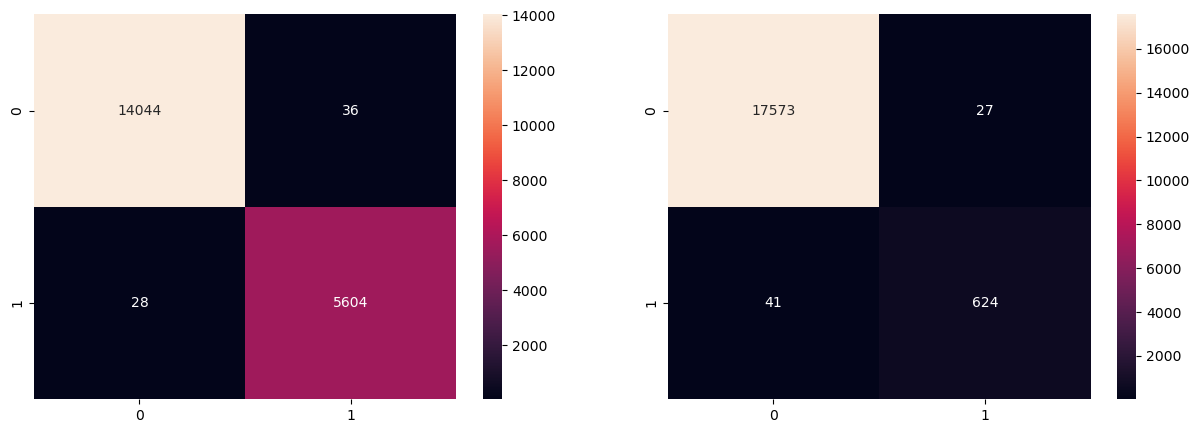

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17600
         1.0       0.96      0.94      0.95       665

    accuracy                           1.00     18265
   macro avg       0.98      0.97      0.97     18265
weighted avg       1.00      1.00      1.00     18265

test f1_score : 0.9483282674772037


In [14]:
model = LGBMClassifier(random_state=42)
modelTest(model)

# XGBoost

StratifiedShuffleSplit 1 검증 데이터 f1 score :               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     14080
         1.0       0.99      0.99      0.99      5632

    accuracy                           1.00     19712
   macro avg       1.00      1.00      1.00     19712
weighted avg       1.00      1.00      1.00     19712

StratifiedShuffleSplit 2 검증 데이터 f1 score :               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     14080
         1.0       0.99      0.99      0.99      5632

    accuracy                           1.00     19712
   macro avg       1.00      1.00      1.00     19712
weighted avg       1.00      1.00      1.00     19712

StratifiedShuffleSplit 3 검증 데이터 f1 score :               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     14080
         1.0       0.99      1.00      0.99      5632

    accuracy                           1.00     19712

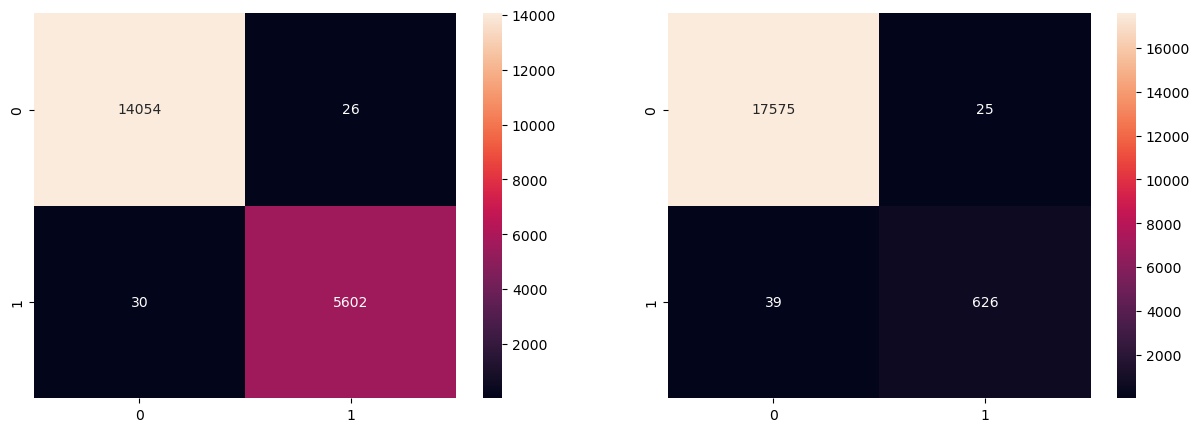

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17600
         1.0       0.96      0.94      0.95       665

    accuracy                           1.00     18265
   macro avg       0.98      0.97      0.97     18265
weighted avg       1.00      1.00      1.00     18265

test f1_score : 0.9513677811550152


In [15]:
from xgboost import XGBClassifier
model = XGBClassifier(random_state=42)
modelTest(model)

# Conv1D

In [16]:
# !pip install tensorflow

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from tensorflow.keras.optimizers import Adam

def create_cnn_model(input_shape):
    model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid') # Binary classification output
    ])

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [18]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding
# from tensorflow.keras.optimizers import Adam

# def create_cnn_model(input_shape):
#     model = Sequential()
#     model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
#     model.add(GlobalMaxPooling1D())
#     model.add(Dense(50, activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))  # 이진 분류의 경우 sigmoid 사용
#     model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
#     return model

In [19]:
# x_train과 x_test의 차원을 CNN에 맞게 변환 (예: (samples, timesteps, features))
x_train_cnn = x_train.values.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test_cnn = x_test.values.reshape((x_test.shape[0], x_test.shape[1], 1))

In [20]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def modelTest_CNN():
    fold_f1_score = []
    n_iter = 0
    idx_list = []

    input_shape = (x_train_cnn.shape[1], x_train_cnn.shape[2])  # CNN 모델 입력 크기 정의

    for train_idx, val_idx in strat_folder.split(x_train_cnn, y_train):
        train_data, val_data = x_train_cnn[train_idx], x_train_cnn[val_idx]
        train_label, val_label = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # CNN 모델 생성 및 학습
        model = create_cnn_model(input_shape)
        model.fit(train_data, train_label, epochs=10, batch_size=32, verbose=0)

        val_pred = (model.predict(val_data) > 0.5).astype("int32")  # 이진 분류일 때 예측값을 이진으로 변환
        val_f1_score = f1_score(val_label, val_pred)
        val_report = classification_report(val_label, val_pred)

        n_iter += 1
        fold_f1_score.append([n_iter, val_f1_score])
        idx_list.append([train_idx, val_idx])

        print(f"StratifiedShuffleSplit {n_iter} 검증 데이터 f1 score : {val_report}")

    fold_f1_score.sort(key=lambda x : x[1], reverse=True)
    print(pd.DataFrame(fold_f1_score, columns=['Fold', 'F1']))

    best_fold_train_idx = idx_list[fold_f1_score[0][0]-1][0]
    best_fold_val_idx = idx_list[fold_f1_score[0][0]-1][1]

    # 최적의 fold에서 다시 학습 (train set 전체로 학습)
    model.fit(x_train_cnn[best_fold_train_idx], y_train.iloc[best_fold_train_idx], epochs=10)

    plt.figure(figsize=(15,5))

    # validation confusion matrix
    plt.subplot(1,2,1)
    pred_val = (model.predict(x_train_cnn[best_fold_val_idx]) > 0.5).astype("int32")
    cm_val = confusion_matrix(y_train.iloc[best_fold_val_idx], pred_val)
    sns.heatmap(cm_val, annot=True, fmt='.0f')

    # test confusion matrix
    plt.subplot(1,2,2)
    pred_test = (model.predict(x_test_cnn) > 0.5).astype("int32")
    cm_test = confusion_matrix(y_test, pred_test)
    sns.heatmap(cm_test, annot=True, fmt='.0f')
    plt.show()

    print(classification_report(y_test, pred_test))
    print(f'test f1_score : {f1_score(y_test, pred_test)}')

In [21]:
modelTest_CNN()

c:\Users\Playdata\AppData\Local\anaconda3\envs\ag\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


KeyboardInterrupt: 

# 트랜스포머

In [ ]:
!pip install transformers
# pip install torch

In [ ]:
train_df = pd.read_csv('train_resample.csv')
train_df = train_df.drop('Unnamed: 0',axis=1)

NameError: name 'pd' is not defined

In [ ]:
unique_values = train_df.apply(lambda x: len(x.unique().tolist()))
print(unique_values)

NameError: name 'train_df' is not defined

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load data
train_df = pd.read_csv('train_resample.csv')
train_df = train_df.drop('Unnamed: 0',axis=1)
test_df = pd.read_csv('test_resample.csv')
test_df = test_df.drop('Unnamed: 0',axis=1)

# Encode labels (passorfail column)
label_encoder = LabelEncoder()
train_df['passorfail'] = label_encoder.fit_transform(train_df['passorfail'])
test_df['passorfail'] = label_encoder.fit_transform(test_df['passorfail'])

# Convert all values in the DataFrame to strings
train_df = train_df.astype(str)
test_df = test_df.astype(str)

# Split data into features and labels
x_train = train_df.drop(columns=['passorfail'])
y_train = train_df['passorfail']
x_test = test_df.drop(columns=['passorfail'])
y_test = test_df['passorfail']

train_strings = x_train.apply(lambda row: ' '.join(row.astype(str)), axis=1)
train_list = train_strings.tolist()
test_strings = x_train.apply(lambda row: ' '.join(row.astype(str)), axis=1)
test_list = test_strings.tolist()

y_train = list(y_train)
y_test = list(y_test)

In [ ]:
len(train_list[0])
train_list[7]

'0.6456456456456456 1 0.1185567010309278 0.2432989690721649 0.7266666666666667 0.2860824742268041 0.9136363636363636 0.0853080568720379 0.1218487394957983 0.0344827586206896 0.5558739255014327 0.0973389355742296 0.0176369547880498 0.3509142053445851 0.9525101763907732 1 1.0 1 1'

In [ ]:
from transformers import BertTokenizer

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode sequences in the training set
train_encodings = tokenizer(train_list, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_list, truncation=True, padding=True, max_length=512)

c:\Users\greatsangho\AppData\Local\miniconda3\envs\ag\lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
import torch

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = CustomDataset(train_encodings, y_train)
test_dataset = CustomDataset(test_encodings, y_test)

In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Load pre-trained BERT model with a classification head
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
trainer.train()

c:\Users\greatsangho\AppData\Local\miniconda3\envs\ag\lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: Accelerator.__init__() got an unexpected keyword argument 'use_seedable_sampler'

In [ ]:
from sklearn.metrics import classification_report

# Make predictions on the test set
predictions = trainer.predict(test_dataset)

# Convert logits to predicted class labels
preds = torch.argmax(predictions.predictions, axis=-1)

# Print classification report
print(classification_report(y_test, preds.numpy()))

In [ ]:
TP = 17562.
FN = 37.
FP = 28.
TN = 500.
aT = TP/(TP+FN); bT = TP/(TP+FP)
aF = TN/(TN+FN); bF = TN/(TN+FP)

def f1_johwa(a, b):
    return (2*a*b)/(a+b)

print(f'pass f1 score : {f1_johwa(aT,bT)}')
print(f'fail f1 score : {f1_johwa(aF,bF)}')


pass f1 score : 0.9981528318508625
fail f1 score : 0.9389671361502349
